In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES'] = '5'

In [2]:
# import librarys
import torch
import numpy as np
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
import os
import random
import cv2
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

is_cuda_available = torch.cuda.is_available()

device = torch.device("cuda" if is_cuda_available else "cpu")

In [3]:
# set up random seed

seed_value = 42

torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # if using multiple GPUs
np.random.seed(seed_value)
random.seed(seed_value)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
!nvidia-smi

Sun Apr  7 13:53:19 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.05              Driver Version: 535.86.05    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 3090        On  | 00000000:03:00.0 Off |                  N/A |
| 30%   27C    P8              23W / 350W |      5MiB / 24576MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Load images and masks for segmentation

# Function to load image paths and their corresponding mask paths
def load_images_and_masks(directory):
    image_paths = []
    mask_paths = []
    for filename in os.listdir(directory):
        if filename.endswith(".png") and not "_mask" in filename:
            image_paths.append(os.path.join(directory, filename))
            mask_paths.append(os.path.join(directory, filename[:-4] + "_mask.png"))
    return image_paths, mask_paths

# Load benign and malignant images and masks
benign_images, benign_masks = load_images_and_masks("./Dataset_BUSI_with_GT/benign/")
malignant_images, malignant_masks = load_images_and_masks("./Dataset_BUSI_with_GT/malignant/")

# Combine benign and malignant images and masks
images = benign_images + malignant_images
masks = benign_masks + malignant_masks

# Split the dataset into training and testing sets
images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

class ToLabel:

    def __call__(self, image):
        return torch.from_numpy(image).type(torch.LongTensor)
    
# Dataset class for segmentation
class BreastCancerSegmentation(data.Dataset):
    def __init__(self, images, masks, img_width, img_height, is_augment=True):
        self.images = images
        self.masks = masks
        self.img_width = img_width
        self.img_height = img_height
        self.is_augment = is_augment

    def __getitem__(self, index):
        image = Image.open(self.images[index]).convert("RGB").resize((self.img_width, self.img_height))
        label = Image.open(self.masks[index]).resize((self.img_width, self.img_height))
        label = np.array(label, dtype=np.float32)
        image = np.array(image)
        img_new = np.float32(image)
        img_new = img_new /127.5 -1

        if self.is_augment == True:
            flipCode = random.choice([-1, 0, 1, 2, 3])
            if flipCode == 2:
                height, width = self.img_height, self.img_width
                center = (width / 2, height / 2)
                degree = random.choice([-5, -4, -3, -2, -1, 1, 2, 3, 4, 5])
                M = cv2.getRotationMatrix2D(center, degree, 1.0)
                img_new = cv2.warpAffine(img_new, M, (height, width))
                label = cv2.warpAffine(label, M, (height, width))
            elif flipCode != 3:
                img_new = cv2.flip(img_new, flipCode)
                label = cv2.flip(label, flipCode)

        tfms = transforms.Compose([
            transforms.ToTensor()
        ])

        y_transform = transforms.Compose([
            ToLabel(),
        ])
        img_new = tfms(img_new)
        label = y_transform(label)

        return img_new, label

    def __len__(self):
        return len(self.images)


# Load training set and test set into Torch datasets
train_dataset = BreastCancerSegmentation(images_train, masks_train, 224, 224, is_augment=True)
test_dataset = BreastCancerSegmentation(images_test, masks_test, 224, 224, is_augment=False)

# DataLoader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print the number of samples in training set and testing set
print('Training samples #: ', len(train_dataset))
print('Test samples #: ', len(test_dataset))

Training samples #:  517
Test samples #:  130


In [6]:
from models.vmamba import VSSM

class UNetVmamba(nn.Module):
    def __init__(self, n_classes, is_pretrain):
        super(UNetVmamba, self).__init__()

        # Load a pretrained ResNet50 model
        vmamba = VSSM(
            patch_size=4,
            in_chans=3,
            num_classes=1000,
            depths=[ 2, 2, 4, 2 ],
            dims=96,
            # ===================
            ssm_d_state=1,
            ssm_ratio=2.0,
            ssm_rank_ratio=2.0,
            ssm_dt_rank="auto",
            ssm_act_layer="silu",
            ssm_conv=3,
            ssm_conv_bias=False,
            ssm_drop_rate=0.0,
            ssm_init="v0",
            forward_type="v2",
            # ===================
            mlp_ratio=4.0,
            mlp_act_layer="gelu",
            mlp_drop_rate=0.0,
            # ===================
            drop_path_rate=0.2,
            patch_norm=True,
            norm_layer="ln",
            downsample_version="v3",
            patchembed_version="v2",
            use_checkpoint=False,
        )
        if is_pretrain:
            state_dict = torch.load('./pretrained/vssmtiny_dp02_ckpt_epoch_258.pth')['model']
            vmamba.load_state_dict(state_dict)
        
        print(vmamba)
        # Remove the last fully connected layer (fc), pool layer and the last downsample layer.
        self.enc_features1 = vmamba.patch_embed
        self.enc_features2 = vmamba.layers[0]
        self.enc_features3 = vmamba.layers[1]
        self.enc_features4 = vmamba.layers[2]
        self.enc_features5 = vmamba.layers[3]
        # Now, self.enc_features contains the encoder part of ResNet50
 
        # Decoder
        # Assuming that the output feature size of ResNet50's last layer is 2048
        self.upconv3 = self._make_up_block(768, 384)
        self.dec3 = self._make_dec_block(1536, 768)  # Concatenation will double the filter size
        self.upconv2 = self._make_up_block(384, 192)
        self.dec2 = self._make_dec_block(768, 384)  # Adjust the sizes according to skip connections
        self.upconv1 = self._make_up_block(192, 96)
        self.dec1 = self._make_dec_block(384, 192)   # Adjust the sizes according to skip connections
        self.upconv0 = self._make_up_block(96, 96)
        self.dec0 = self._make_dec_block(192, 96)   # Adjust the sizes according to skip connections

        self.upconv_final = self._make_up_block(96, 96)

        # Final Convolution to get desired number of classes
        self.final_conv = nn.Conv2d(96, n_classes, kernel_size=1)

    def _make_dec_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    
    def _make_up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, 2, stride=2), 
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        input_shape = (x.shape[1], x.shape[2])
        # Encoder: extract skip connections for the decoder
        x1 = self.enc_features1(x) # Initial conv and bn
        x2 = self.enc_features2(x1)  # Layer1
        x3 = self.enc_features3(x2)  # Layer2
        x4 = self.enc_features4(x3)  # Layer3
        x5 = self.enc_features5(x4)  # Layer4
        
        x1 = x1.permute(0, 3, 1, 2)
        x2 = x2.permute(0, 3, 1, 2)
        x3 = x3.permute(0, 3, 1, 2)
        x4 = x4.permute(0, 3, 1, 2)
        x5 = x5.permute(0, 3, 1, 2)

        # Decoder with skip connections
        
        x = self.dec3(torch.cat([x5, x4], dim=1))  # Use skip connection from layer3
        x = self.upconv3(x)
        
        x = self.dec2(torch.cat([x, x3], dim=1))  # Use skip connection from layer2
        x = self.upconv2(x)

        x = self.dec1(torch.cat([x, x2], dim=1))  # Use skip connection from layer1
        x = self.upconv1(x)

        x = self.dec0(torch.cat([x, x1], dim=1))  # Use skip connection from layer1
        
        x = self.upconv0(x)

        x = self.upconv_final(x)
        
        return self.final_conv(x)

model = UNetVmamba(2, True)
model = model.to(device)


# optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)

# loss
loss_function = torch.nn.CrossEntropyLoss()


VSSM(
  (patch_embed): Sequential(
    (0): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): Permute()
    (2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
    (3): Permute()
    (4): GELU(approximate='none')
    (5): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): Permute()
    (7): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): ModuleList(
    (0): Sequential(
      (blocks): Sequential(
        (0): VSSBlock(
          (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (op): SS2D(
            (out_norm): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
            (in_proj): Linear(in_features=96, out_features=384, bias=False)
            (act): SiLU()
            (conv2d): Conv2d(192, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=192, bias=False)
            (out_proj): Linear(in_features=192, out_features=96, bias=False)
            (dropout): Identity()
   

Epoch 1, Train loss: 0.4721432915239623
Epoch 1, Test loss: 0.46108206113179523
Epoch 2, Train loss: 0.27821153357173456
Epoch 2, Test loss: 0.2544812824991014
Epoch 3, Train loss: 0.21471261797529279
Epoch 3, Test loss: 0.19556122024854025
Epoch 4, Train loss: 0.18509561545921094
Epoch 4, Test loss: 0.15603875203265083
Epoch 5, Train loss: 0.16077598771362595
Epoch 5, Test loss: 0.14050105628040102
Epoch 6, Train loss: 0.14575830124544376
Epoch 6, Test loss: 0.1295253278480636
Epoch 7, Train loss: 0.12993562695654956
Epoch 7, Test loss: 0.11634839243359035
Epoch 8, Train loss: 0.12419441387508855
Epoch 8, Test loss: 0.1207900523311562
Epoch 9, Train loss: 0.11202920295975426
Epoch 9, Test loss: 0.11266164109110832
Epoch 10, Train loss: 0.10793769337011105
Epoch 10, Test loss: 0.10942773272593816
Epoch 11, Train loss: 0.09835273817633138
Epoch 11, Test loss: 0.10581167414784431
Epoch 12, Train loss: 0.09405679187991402
Epoch 12, Test loss: 0.09811391515864266
Epoch 13, Train loss: 0.09

Epoch 100, Train loss: 0.04794661113710114
Epoch 100, Test loss: 0.0899496583475007


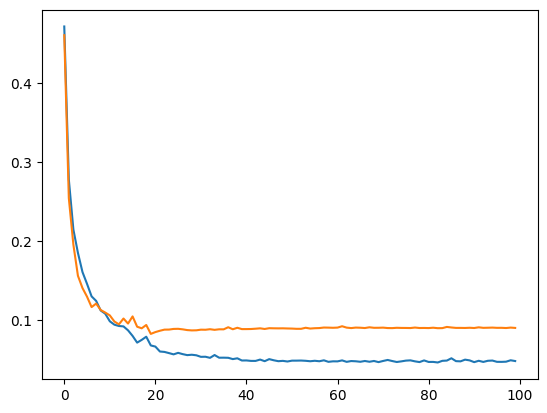

In [7]:
# Train the model
epoch_training_loss = []
epoch_test_loss = []
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.1)
for epoch in range(100):
    model.train()
    train_loss = []
    for batch_idx, (image, seg_label) in enumerate(train_loader):
        image, seg_label = image.to(device), seg_label.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(image)

        # Calculate loss
        loss = loss_function(output, seg_label)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())

    print(f'Epoch {epoch+1}, Train loss: {np.mean(train_loss)}')
    epoch_training_loss.append(np.mean(train_loss))
    scheduler.step()

    # Evaluate on test data
    model.eval()
    test_loss = []
    with torch.no_grad():
        for image, seg_label in test_loader:
            image, seg_label = image.to(device), seg_label.to(device)
            y_predict = model(image)
            loss = loss_function(y_predict, seg_label)
            test_loss.append(loss.item())
    print(f'Epoch {epoch+1}, Test loss: {np.mean(test_loss)}')
    epoch_test_loss.append(np.mean(test_loss))


# Draw curves here

import matplotlib.pyplot as plt

plt.plot(epoch_training_loss)

plt.plot(epoch_test_loss)
torch.save(model, "./save_models/UNetVmamba.pt")

./Dataset_BUSI_with_GT/malignant/malignant (30).png


/tmp/ipykernel_392607/1266470776.py:36: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)


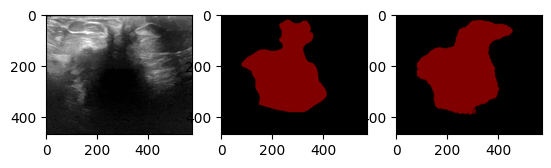

0.780650719284374
0.907991525339828
./Dataset_BUSI_with_GT/benign/benign (110).png


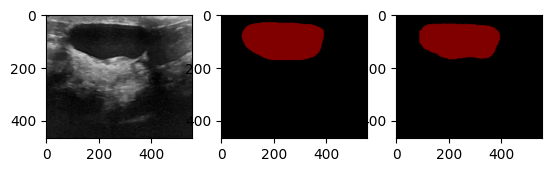

0.9026753130825172
0.9835506172401246
./Dataset_BUSI_with_GT/benign/benign (245).png


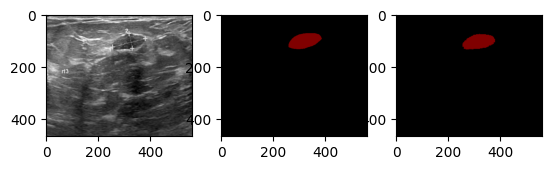

0.8384121232086971
0.9961576123144412
./Dataset_BUSI_with_GT/benign/benign (22).png


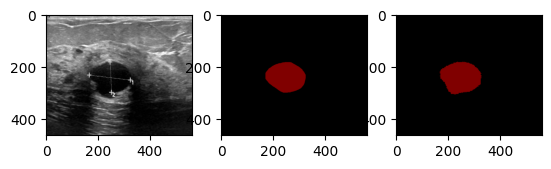

0.9045075125208681
0.994202569518489
./Dataset_BUSI_with_GT/benign/benign (399).png


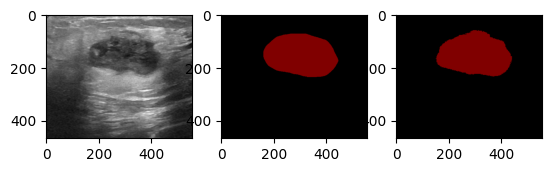

0.9186853962364167
0.9863691697989142
./Dataset_BUSI_with_GT/malignant/malignant (133).png


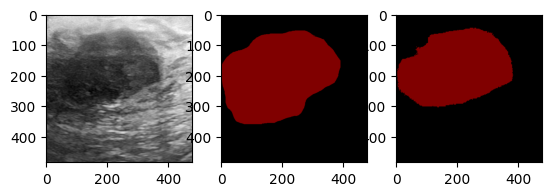

0.788220803941328
0.883188507834164
./Dataset_BUSI_with_GT/benign/benign (219).png


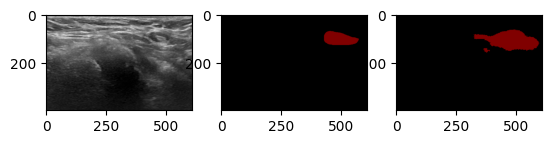

0.42715254948590614
0.9650985890284283
./Dataset_BUSI_with_GT/benign/benign (427).png


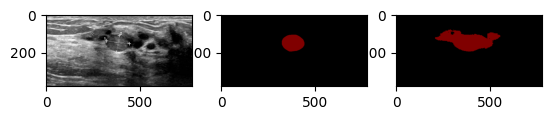

0.380708357897601
0.9525841565250603
./Dataset_BUSI_with_GT/benign/benign (381).png


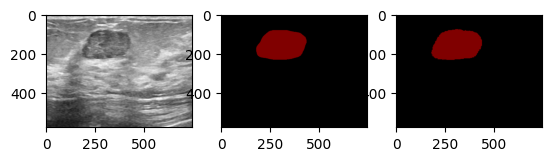

0.942634110919488
0.9952495133006111
./Dataset_BUSI_with_GT/benign/benign (55).png


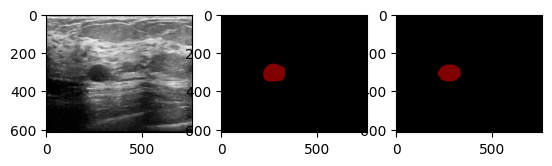

0.9054246575342466
0.9981248098735387
./Dataset_BUSI_with_GT/malignant/malignant (1).png


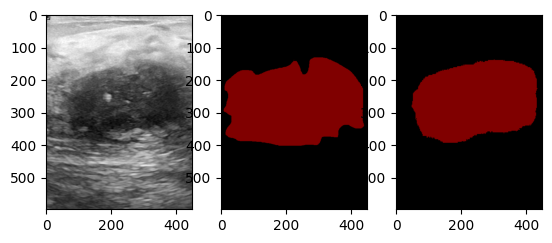

0.7915956358677122
0.8992822054931362
./Dataset_BUSI_with_GT/benign/benign (362).png


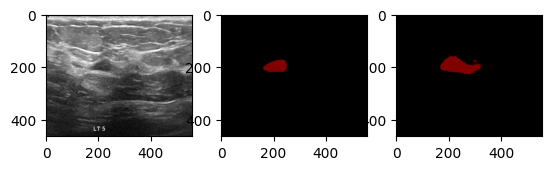

0.45325022261798753
0.9855752288620719
./Dataset_BUSI_with_GT/benign/benign (15).png


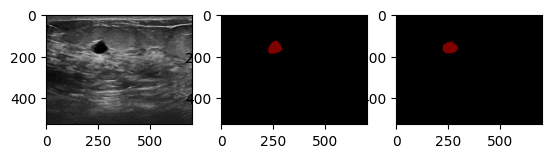

0.8372230428360413
0.9984940911525806
./Dataset_BUSI_with_GT/benign/benign (14).png


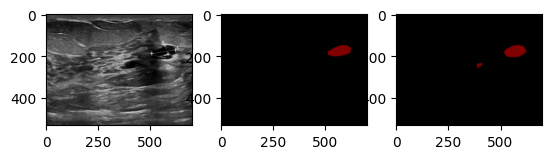

0.771583069177699
0.9966624072626018
./Dataset_BUSI_with_GT/malignant/malignant (62).png


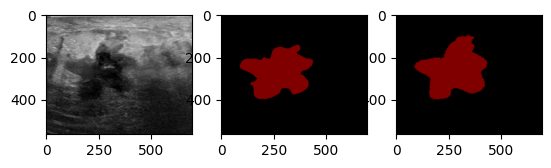

0.8351646596607787
0.9695771874594696
./Dataset_BUSI_with_GT/benign/benign (435).png


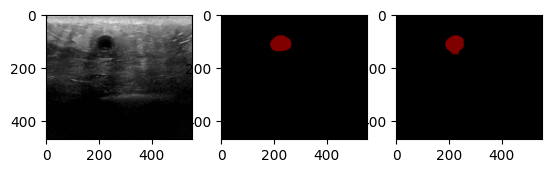

0.8068262621474283
0.9968099763585978
./Dataset_BUSI_with_GT/benign/benign (191).png


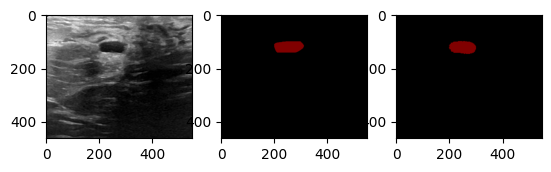

0.8192255740657362
0.9967950253045325
./Dataset_BUSI_with_GT/malignant/malignant (145).png


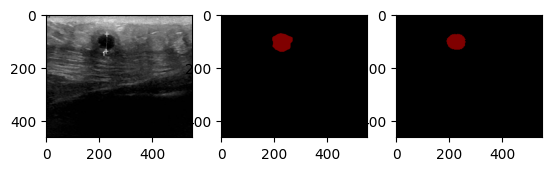

0.7919350990217132
0.9965228625773085
./Dataset_BUSI_with_GT/benign/benign (335).png


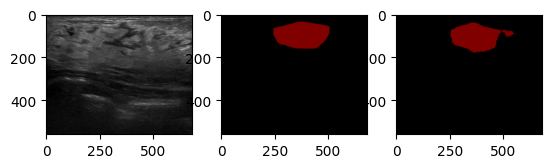

0.7495205885429378
0.979998997722603
./Dataset_BUSI_with_GT/benign/benign (259).png


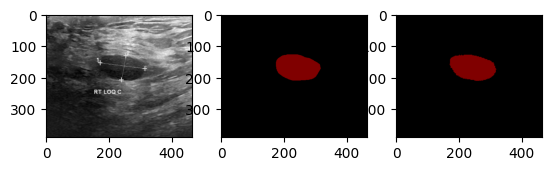

0.9203330592105263
0.9955045621443529
./Dataset_BUSI_with_GT/benign/benign (45).png


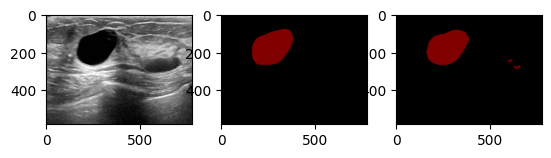

0.9293694141012909
0.9945751658912364
./Dataset_BUSI_with_GT/benign/benign (344).png


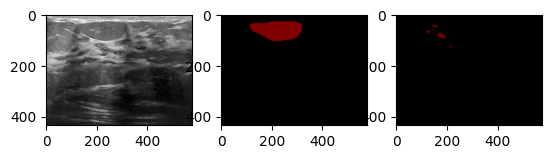

0.05313736574335783
0.9529732157897692
./Dataset_BUSI_with_GT/benign/benign (199).png


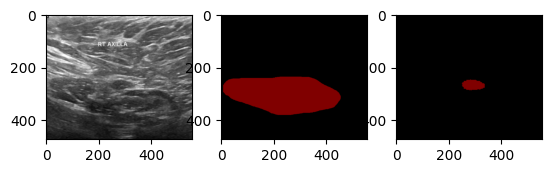

0.05566482278221676
0.8229038194804645
./Dataset_BUSI_with_GT/benign/benign (240).png


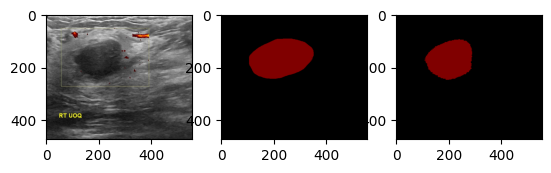

0.7286854559581832
0.9683028272458697
./Dataset_BUSI_with_GT/malignant/malignant (140).png


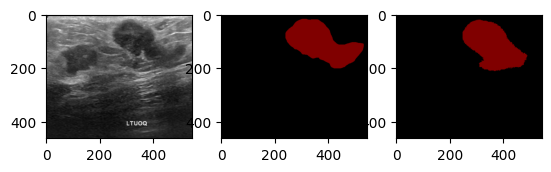

0.7325304832154147
0.9611147342942307
./Dataset_BUSI_with_GT/benign/benign (385).png


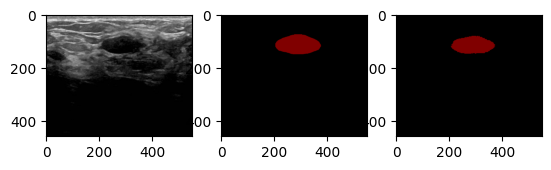

0.8501381922407616
0.9940013029956608
./Dataset_BUSI_with_GT/benign/benign (125).png


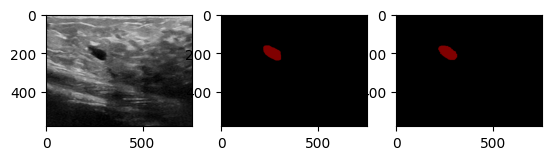

0.8712265953381735
0.9984412869327117
./Dataset_BUSI_with_GT/benign/benign (72).png


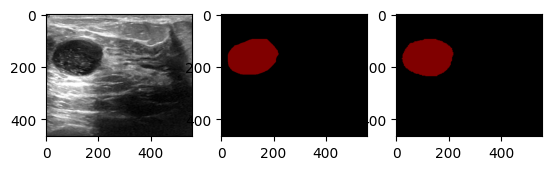

0.9059963223752074
0.9912229275891526
./Dataset_BUSI_with_GT/malignant/malignant (56).png


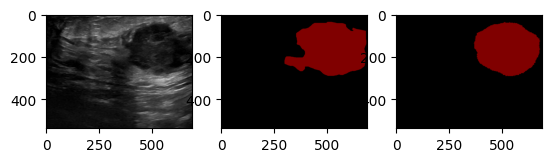

0.82350395129988
0.9595149869170732
./Dataset_BUSI_with_GT/benign/benign (196).png


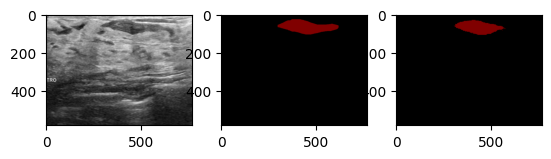

0.7680929405789741
0.9915475229128536
./Dataset_BUSI_with_GT/malignant/malignant (120).png


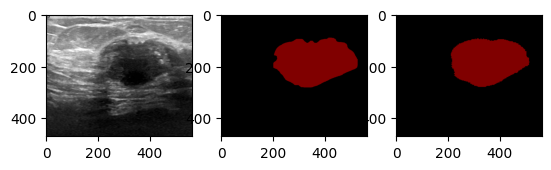

0.9042486145822014
0.9802837952128016
./Dataset_BUSI_with_GT/benign/benign (346).png


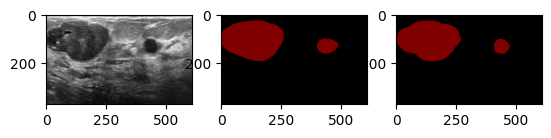

0.9080718636433434
0.9812963425810214
./Dataset_BUSI_with_GT/benign/benign (139).png


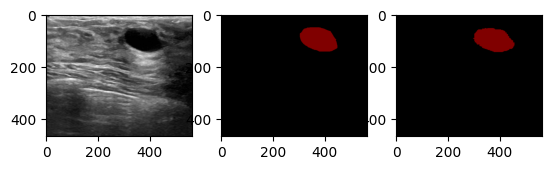

0.9032316302581693
0.9957708361277902
./Dataset_BUSI_with_GT/malignant/malignant (59).png


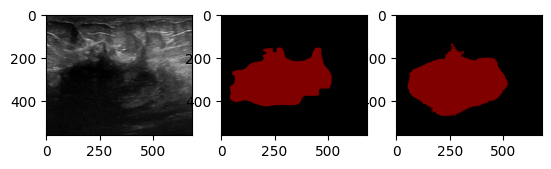

0.7925846989814042
0.9279938942288465
./Dataset_BUSI_with_GT/malignant/malignant (8).png


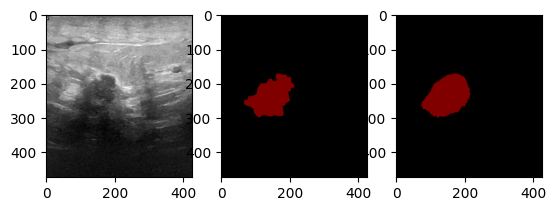

0.8163407821229051
0.9876058373521419
./Dataset_BUSI_with_GT/benign/benign (319).png


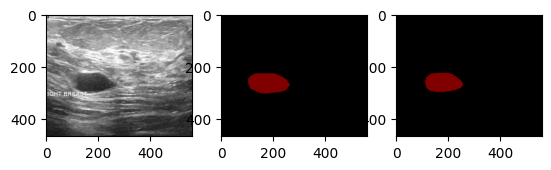

0.8476457062881135
0.9939772606020368
./Dataset_BUSI_with_GT/benign/benign (303).png


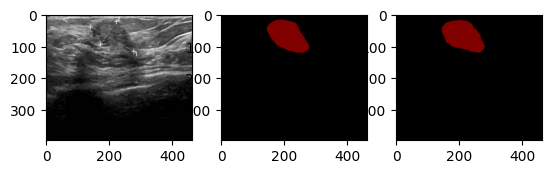

0.902122994119406
0.9943957128915725
./Dataset_BUSI_with_GT/benign/benign (434).png


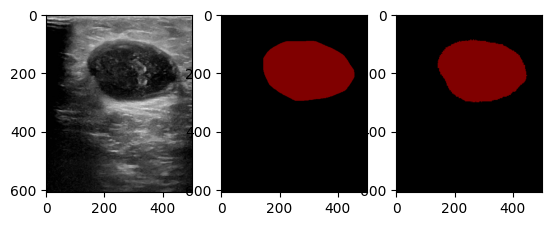

0.9355705996131528
0.9870257848406949
./Dataset_BUSI_with_GT/benign/benign (28).png


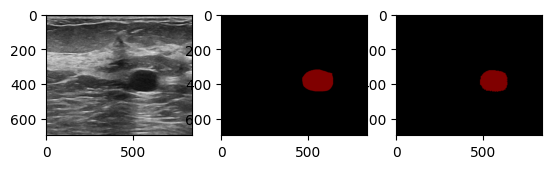

0.8643597137669551
0.9955372046033559
./Dataset_BUSI_with_GT/benign/benign (294).png


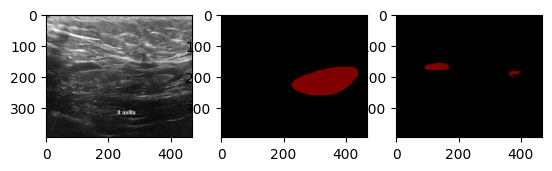

0.02658195020746888
0.9185685772551742
./Dataset_BUSI_with_GT/benign/benign (122).png


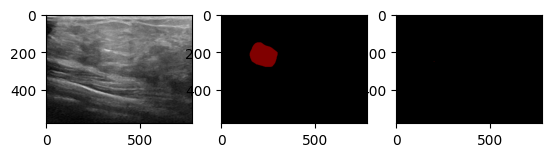

0.000564214683687143
0.968268434134217
./Dataset_BUSI_with_GT/benign/benign (129).png


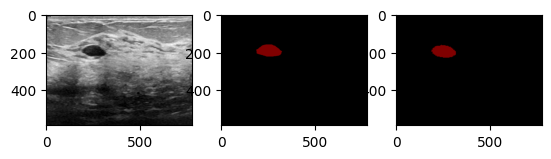

0.8318072968023665
0.9973408756848248
./Dataset_BUSI_with_GT/malignant/malignant (181).png


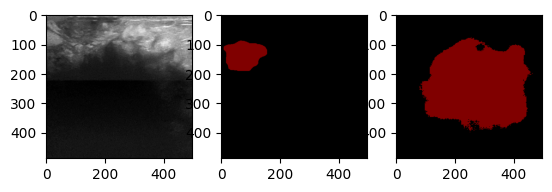

0.002001650846058605
0.6008698450949485
./Dataset_BUSI_with_GT/benign/benign (171).png


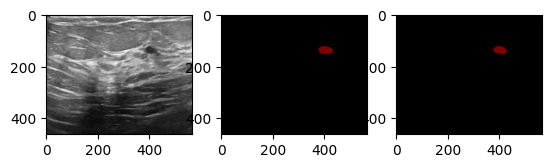

0.8442105263157895
0.9991489524831804
./Dataset_BUSI_with_GT/malignant/malignant (89).png


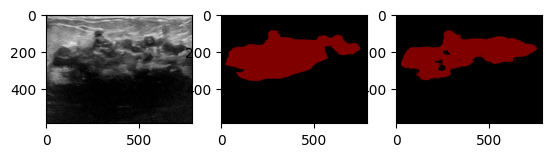

0.7422266277128547
0.9208274580182028
./Dataset_BUSI_with_GT/benign/benign (395).png


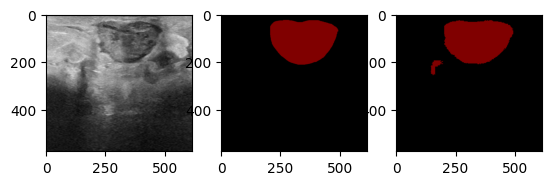

0.9062715675579402
0.9865723863197813
./Dataset_BUSI_with_GT/malignant/malignant (44).png


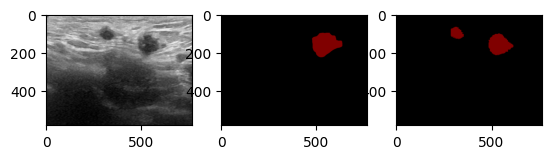

0.5865493250877089
0.9839732064651159
./Dataset_BUSI_with_GT/benign/benign (264).png


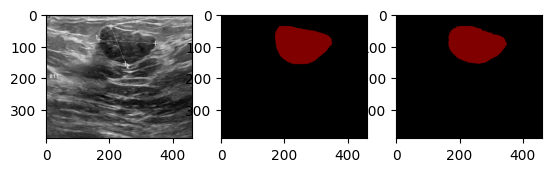

0.9118862134088763
0.9909619773474342
./Dataset_BUSI_with_GT/benign/benign (33).png


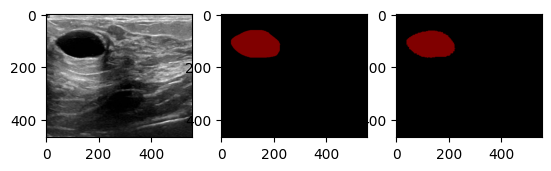

0.9402754537263484
0.9962214676015277
./Dataset_BUSI_with_GT/benign/benign (44).png


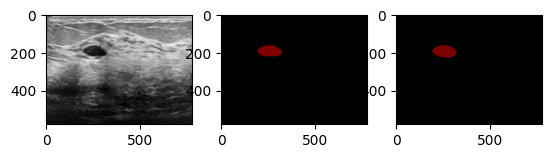

0.8877054169202678
0.9983409243164743
./Dataset_BUSI_with_GT/malignant/malignant (138).png


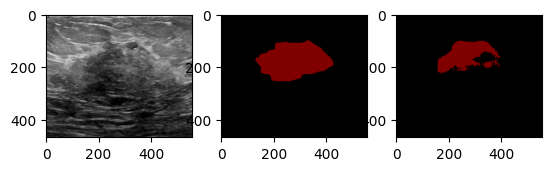

0.5163359263375139
0.9374132051440076
./Dataset_BUSI_with_GT/benign/benign (180).png


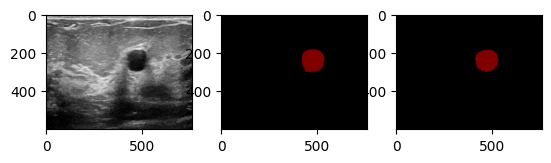

0.8586624886616641
0.9961688649871364
./Dataset_BUSI_with_GT/malignant/malignant (54).png


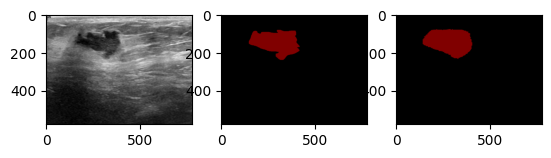

0.8285055114073314
0.9874012485758138
./Dataset_BUSI_with_GT/malignant/malignant (203).png


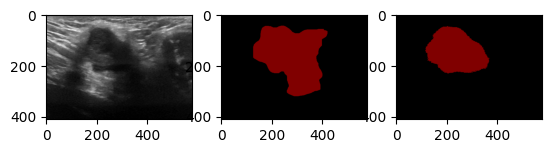

0.5677568393480792
0.8846086610273194
./Dataset_BUSI_with_GT/benign/benign (239).png


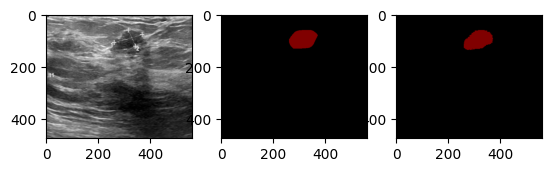

0.828988068935042
0.9955217317513462
./Dataset_BUSI_with_GT/benign/benign (23).png


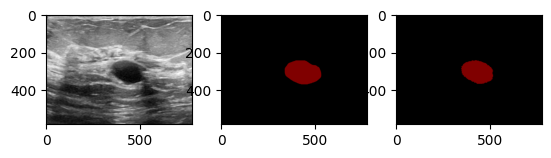

0.8396042730095248
0.9930443037685817
./Dataset_BUSI_with_GT/benign/benign (398).png


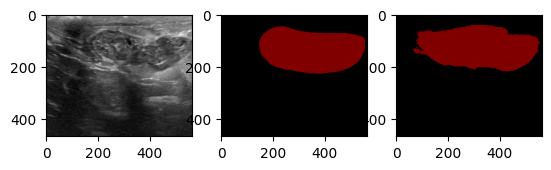

0.7576367267814134
0.9223234709919137
./Dataset_BUSI_with_GT/benign/benign (277).png


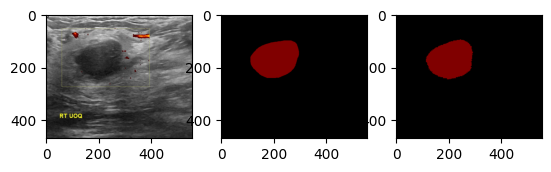

0.912255738948966
0.9923404960046371
./Dataset_BUSI_with_GT/benign/benign (235).png


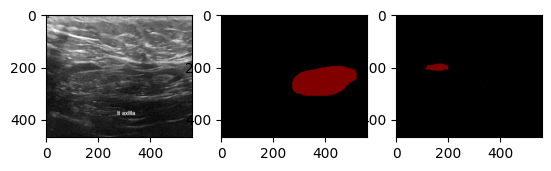

0.0002541942043721403
0.9099567297786122
./Dataset_BUSI_with_GT/benign/benign (334).png


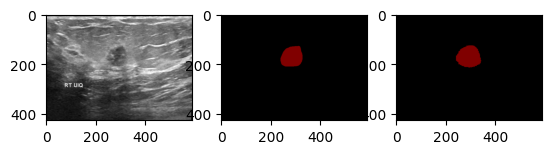

0.8020673278390836
0.9942203840569069
./Dataset_BUSI_with_GT/benign/benign (217).png


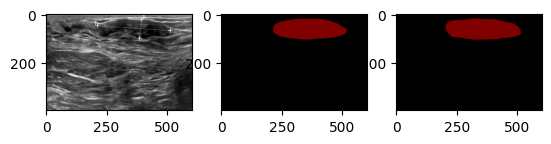

0.9121615583951389
0.9909970142692287
./Dataset_BUSI_with_GT/malignant/malignant (52).png


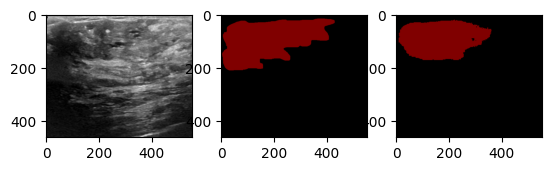

0.70716804194126
0.9268028202809206
./Dataset_BUSI_with_GT/benign/benign (365).png


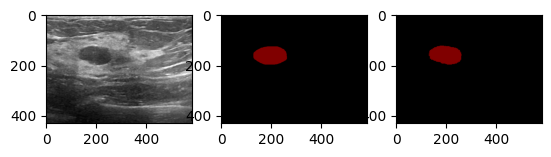

0.8820519069087365
0.9960263215149239
./Dataset_BUSI_with_GT/benign/benign (409).png


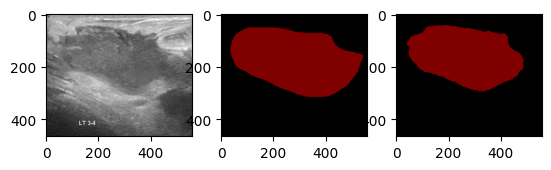

0.791726208222389
0.8893047602395419
./Dataset_BUSI_with_GT/benign/benign (273).png


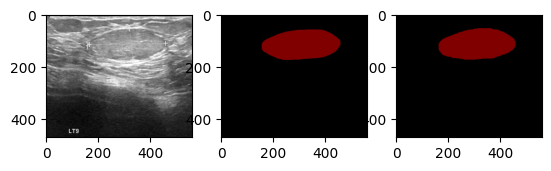

0.9476052146804591
0.9937301550292296
./Dataset_BUSI_with_GT/benign/benign (153).png


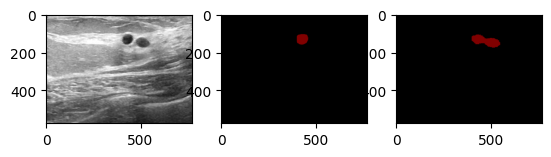

0.375211701308699
0.9907917338906399
./Dataset_BUSI_with_GT/benign/benign (400).png


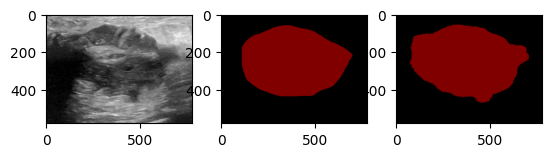

0.8958690832230194
0.9334825032710671
./Dataset_BUSI_with_GT/malignant/malignant (33).png


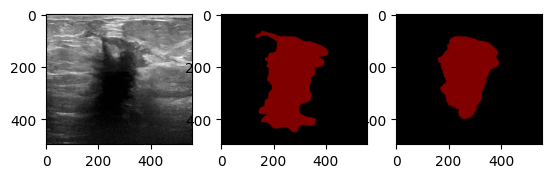

0.7154916615096555
0.9224417231519891
./Dataset_BUSI_with_GT/benign/benign (369).png


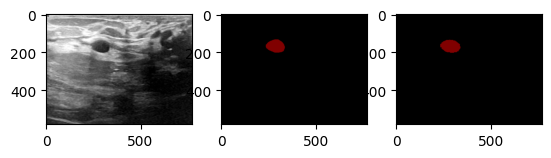

0.9071142807444773
0.9987954443434383
./Dataset_BUSI_with_GT/malignant/malignant (24).png


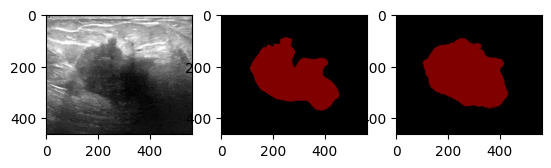

0.8153356616220412
0.9428138819457796
./Dataset_BUSI_with_GT/benign/benign (160).png


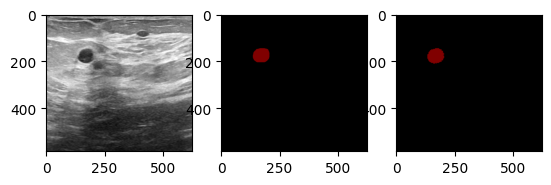

0.8745832264683252
0.9986477891767829
./Dataset_BUSI_with_GT/benign/benign (35).png


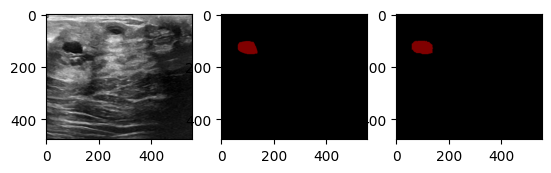

0.8601598173515982
0.9981272119919585
./Dataset_BUSI_with_GT/benign/benign (187).png


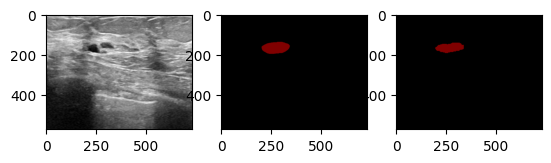

0.7724425887265136
0.9963125845737483
./Dataset_BUSI_with_GT/malignant/malignant (172).png


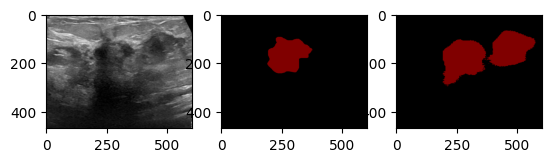

0.3905011420126293
0.8972476302288797
./Dataset_BUSI_with_GT/benign/benign (284).png


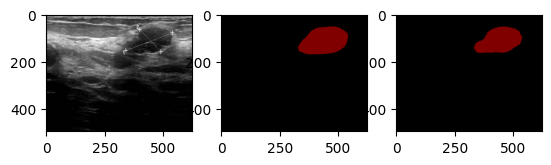

0.8517556617494286
0.9902506012243113
./Dataset_BUSI_with_GT/benign/benign (37).png


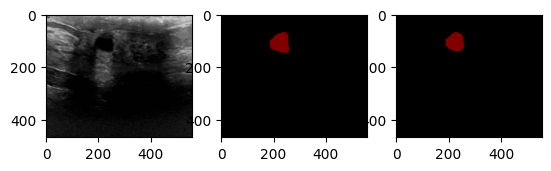

0.838995888335858
0.9971027924563569
./Dataset_BUSI_with_GT/benign/benign (241).png


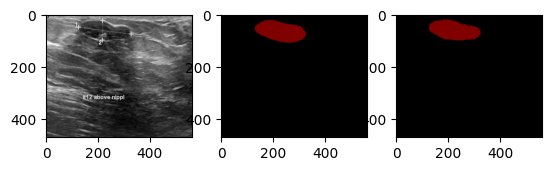

0.8703968253968254
0.9935641515754626
./Dataset_BUSI_with_GT/benign/benign (324).png


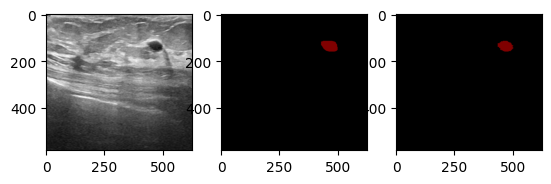

0.8203636363636364
0.9986380003418784
./Dataset_BUSI_with_GT/benign/benign (7).png


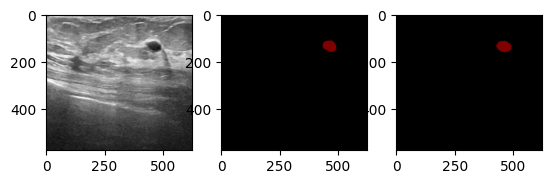

0.833533894905736
0.9988427023318851
./Dataset_BUSI_with_GT/malignant/malignant (36).png


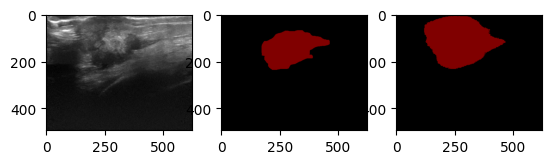

0.5700172977128579
0.9195552742858787
./Dataset_BUSI_with_GT/benign/benign (169).png


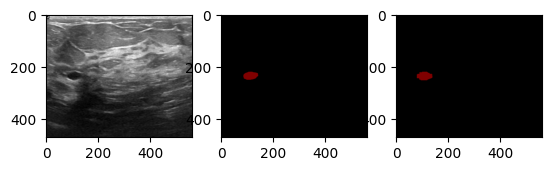

0.7862780813600486
0.9986555340814471
./Dataset_BUSI_with_GT/malignant/malignant (64).png


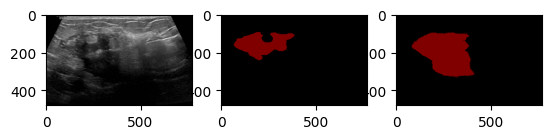

0.4411199053184407
0.9126365144796407
./Dataset_BUSI_with_GT/benign/benign (215).png


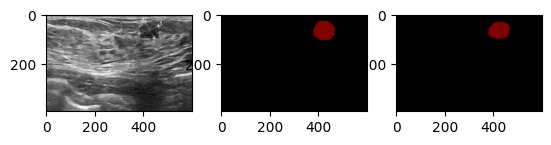

0.8503246183540972
0.9963351865059247
./Dataset_BUSI_with_GT/malignant/malignant (7).png


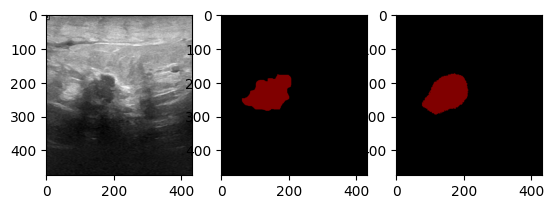

0.773744655880627
0.9861970563266476
./Dataset_BUSI_with_GT/benign/benign (157).png


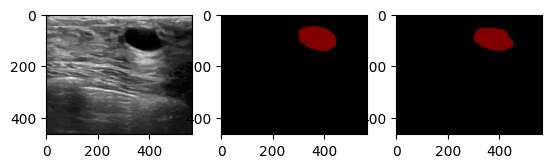

0.888072752710738
0.9949506704168458
./Dataset_BUSI_with_GT/benign/benign (336).png


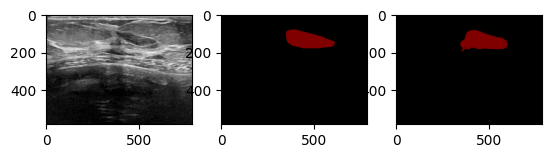

0.7760684582471996
0.9894594398884846
./Dataset_BUSI_with_GT/benign/benign (428).png


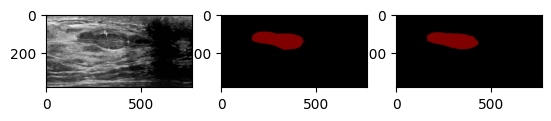

0.8947253823961678
0.9930261321717432
./Dataset_BUSI_with_GT/benign/benign (417).png


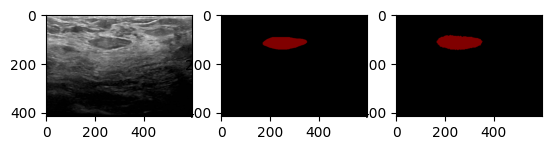

0.8276553106212425
0.993962744102113
./Dataset_BUSI_with_GT/benign/benign (436).png


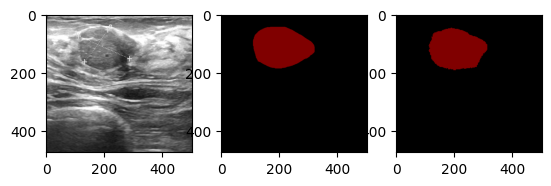

0.8563703672892142
0.9841139124033861
./Dataset_BUSI_with_GT/malignant/malignant (93).png


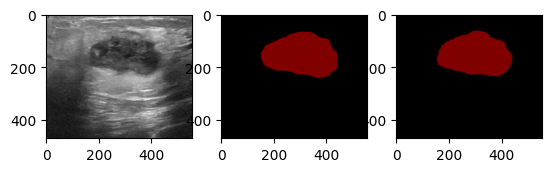

0.9302264625707696
0.9881631019609587
./Dataset_BUSI_with_GT/benign/benign (141).png


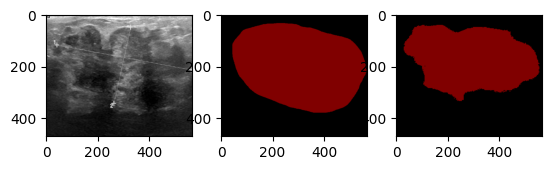

0.7463394396320484
0.782064676311164
./Dataset_BUSI_with_GT/benign/benign (420).png


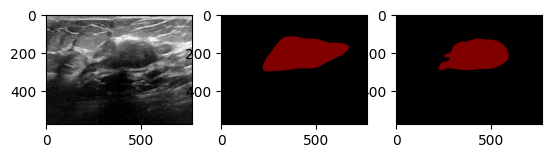

0.7609726123595506
0.9657473074591119
./Dataset_BUSI_with_GT/benign/benign (243).png


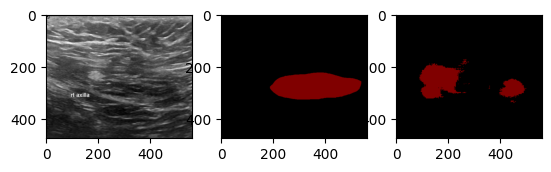

0.16663429792192658
0.8671974436049503
./Dataset_BUSI_with_GT/benign/benign (265).png


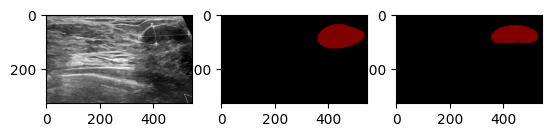

0.7698599076848328
0.983175965665236
./Dataset_BUSI_with_GT/malignant/malignant (55).png


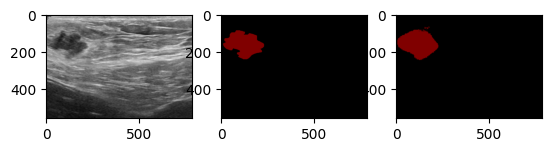

0.8371939658725579
0.9905208493318999
./Dataset_BUSI_with_GT/benign/benign (64).png


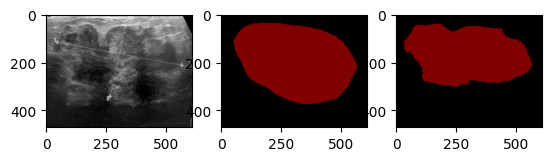

0.7579480149733748
0.8278479520886232
./Dataset_BUSI_with_GT/malignant/malignant (45).png


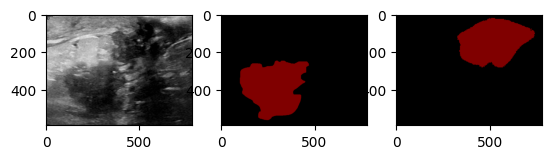

0.008157330186034076
0.6701199954023088
./Dataset_BUSI_with_GT/malignant/malignant (128).png


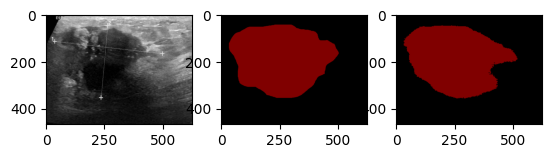

0.8826727272727273
0.9339528980686366
./Dataset_BUSI_with_GT/benign/benign (387).png


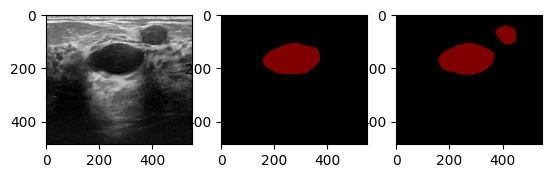

0.7791620913928541
0.978946308859944
./Dataset_BUSI_with_GT/benign/benign (99).png


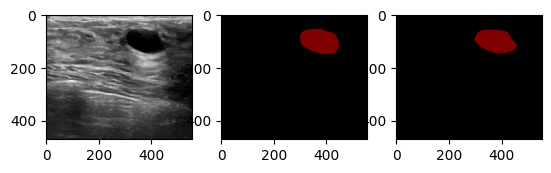

0.8940248027057497
0.9951241895261845
./Dataset_BUSI_with_GT/malignant/malignant (28).png


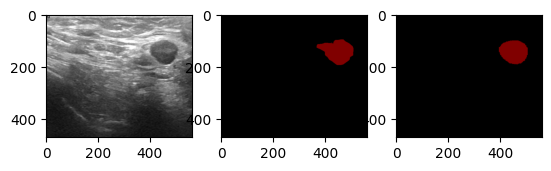

0.8507595077059541
0.9947517614351944
./Dataset_BUSI_with_GT/benign/benign (24).png


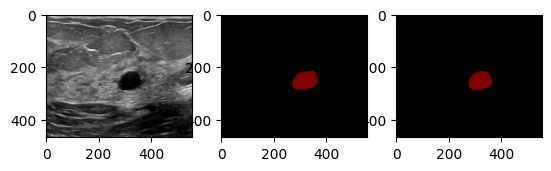

0.8660142348754448
0.9970445669878525
./Dataset_BUSI_with_GT/benign/benign (30).png


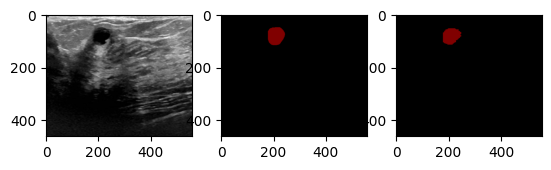

0.8519989409584326
0.9978002172236301
./Dataset_BUSI_with_GT/benign/benign (411).png


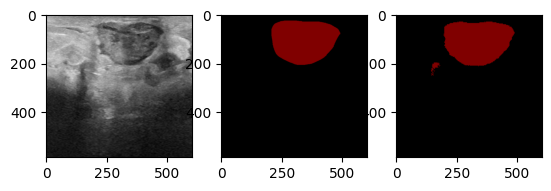

0.9043696357486366
0.9867673233122447
./Dataset_BUSI_with_GT/benign/benign (402).png


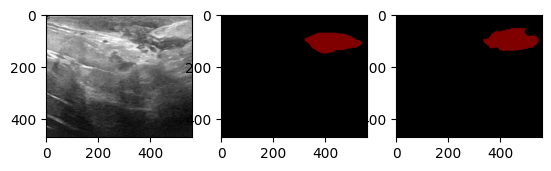

0.7022388059701492
0.982635564452955
./Dataset_BUSI_with_GT/benign/benign (364).png


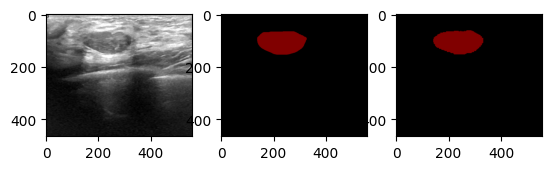

0.8787561146051712
0.9929594611045733
./Dataset_BUSI_with_GT/malignant/malignant (210).png


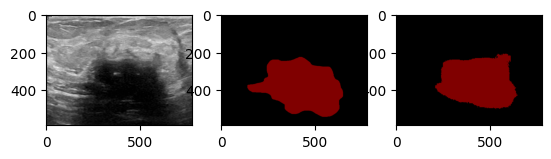

0.761669950964667
0.9300661874063735
./Dataset_BUSI_with_GT/benign/benign (144).png


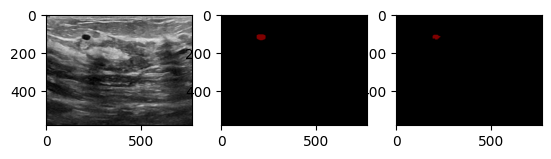

0.5979299363057324
0.9988673295218785
./Dataset_BUSI_with_GT/malignant/malignant (157).png


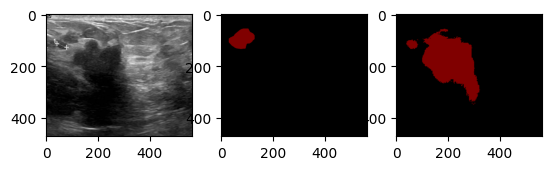

0.03556813794878394
0.8581975463744315
./Dataset_BUSI_with_GT/benign/benign (213).png


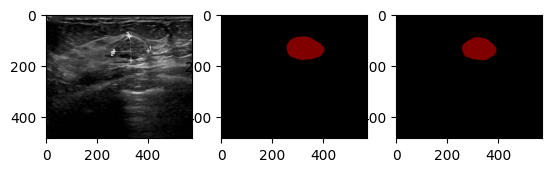

0.8630588235294118
0.9945972640990984
./Dataset_BUSI_with_GT/benign/benign (290).png


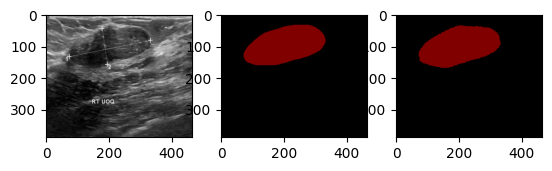

0.9283044377286465
0.9885552875460201
./Dataset_BUSI_with_GT/malignant/malignant (188).png


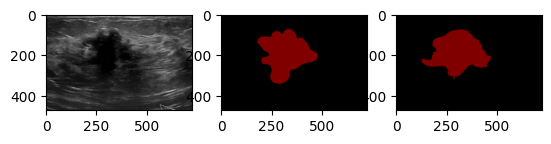

0.7548836941280421
0.9579056051089883
./Dataset_BUSI_with_GT/benign/benign (253).png


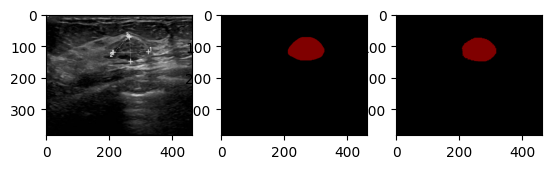

0.8182705718270572
0.9924006485402014
./Dataset_BUSI_with_GT/malignant/malignant (152).png


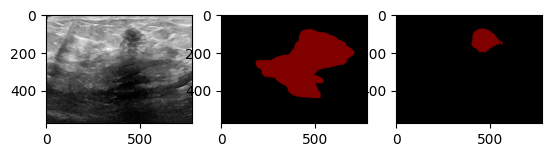

0.13154905726617516
0.8056179567536585
./Dataset_BUSI_with_GT/malignant/malignant (190).png


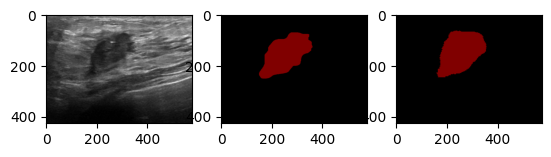

0.8455516014234875
0.9826066046809875
./Dataset_BUSI_with_GT/benign/benign (285).png


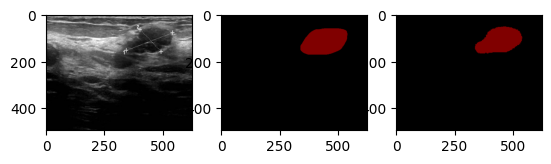

0.8484848484848485
0.9903200693813722
./Dataset_BUSI_with_GT/benign/benign (108).png


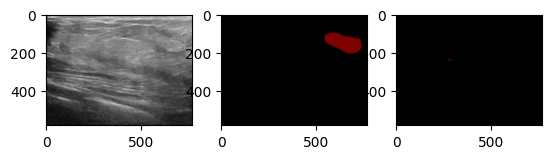

0.0
0.9687794654547567
./Dataset_BUSI_with_GT/benign/benign (173).png


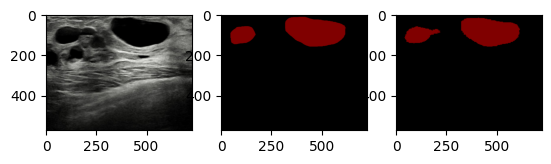

0.8984018526586109
0.9882409451827948
./Dataset_BUSI_with_GT/benign/benign (432).png


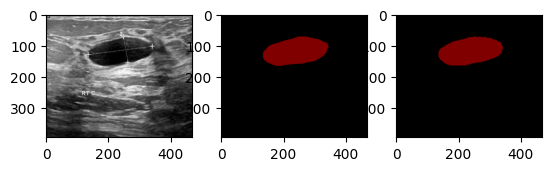

0.9462518639013149
0.9953578223327967
./Dataset_BUSI_with_GT/malignant/malignant (150).png


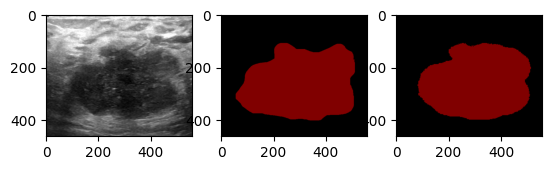

0.893099702451235
0.9307163453591523
./Dataset_BUSI_with_GT/benign/benign (238).png


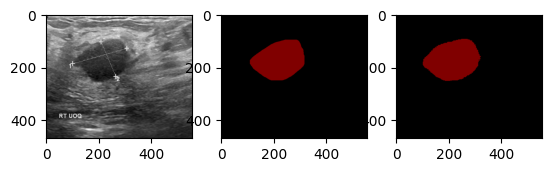

0.9042352200267654
0.9897683259669205
./Dataset_BUSI_with_GT/malignant/malignant (202).png


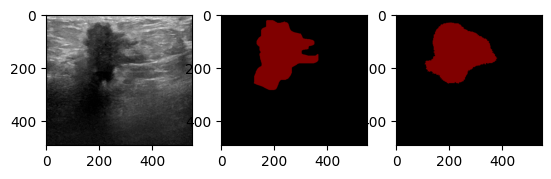

0.7756359915280455
0.960295969375508
./Dataset_BUSI_with_GT/malignant/malignant (46).png


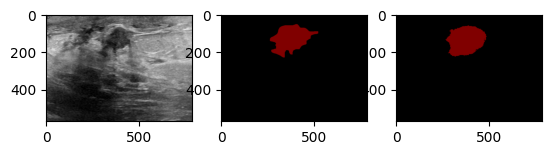

0.7904219170324225
0.9860978060783651
./Dataset_BUSI_with_GT/benign/benign (67).png


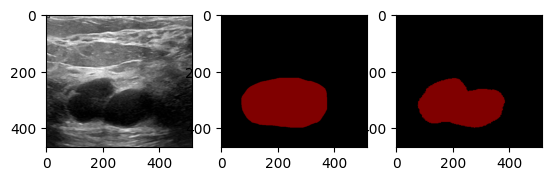

0.8372113775794757
0.9641326360079432
./Dataset_BUSI_with_GT/benign/benign (156).png


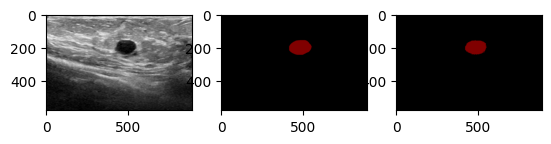

0.885655737704918
0.9977975263615965
./Dataset_BUSI_with_GT/malignant/malignant (148).png


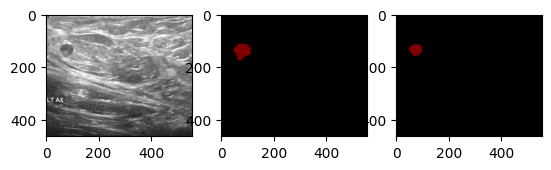

0.5860027855153204
0.9953508377485386
./Dataset_BUSI_with_GT/benign/benign (220).png


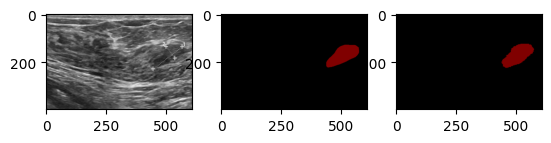

0.8653408410207261
0.9951953697727205
./Dataset_BUSI_with_GT/malignant/malignant (165).png


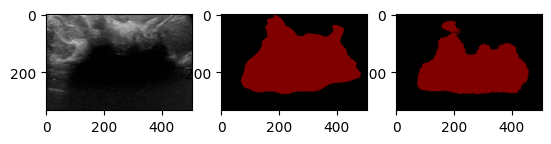

0.7327033002588438
0.8250214012761339
./Dataset_BUSI_with_GT/benign/benign (76).png


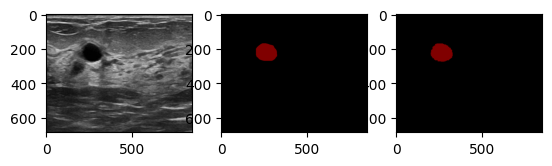

0.9281281837547467
0.9986406450629665
./Dataset_BUSI_with_GT/malignant/malignant (131).png


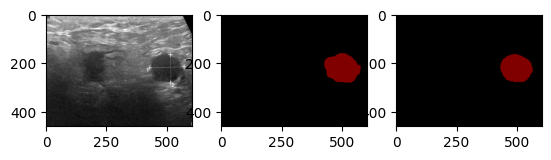

0.8554408260524226
0.9924905381530925
average tumor IoU: 0.742679789417665
average background IoU: 0.962884379055763


In [8]:
# Step 4: IoU and segmentation results
model = torch.load("./save_models/UNetVmamba.pt")
model = model.to(device)
from utility import VOCPalette

total_tumor_IoU = []
total_background_IoU = []
palette = VOCPalette(nb_class=2)

for test_image in images_test:
    image = Image.open(test_image)
    print(test_image)
    label = Image.open(test_image[:-4] + "_mask.png")
    
    image_resize = image.convert("RGB").resize((224, 224))
    image_resize = np.array(image_resize)
    img_new = np.float32(image_resize)
    img_new = img_new /127.5 -1

  
    tfms = transforms.Compose([
            transforms.ToTensor()
        ])

    image_tensor = tfms(img_new).unsqueeze(0).to(device)

    predict = model(image_tensor).squeeze(0)

    predict_label = torch.argmax(predict, 0)

    predict_label = predict_label.cpu().numpy().astype('uint8')

    # resize the predict result to original size
    
    PIL_predicr_pal_U = palette.genlabelpal(predict_label)
    PIL_img_pal = PIL_predicr_pal_U.resize((image.size[0], image.size[1]), Image.ANTIALIAS)
    
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.subplot(1,3,2)
    plt.imshow(label)
    plt.subplot(1,3,3)
    plt.imshow(PIL_img_pal)
    plt.show()

    # Compute IoU between thresh1 and label

    def compute_iou(mask1, mask2):
        intersection = np.logical_and(mask1, mask2)
        union = np.logical_or(mask1, mask2)
        iou = np.sum(intersection) / np.sum(union)
        return iou

    # IoU

    print(compute_iou(np.array(PIL_img_pal), np.array(label)))
    print(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
    total_tumor_IoU.append(compute_iou(np.array(PIL_img_pal), np.array(label)))
    total_background_IoU.append(compute_iou(1 - np.array(PIL_img_pal), 1 - np.array(label)))
print("average tumor IoU:", np.mean(total_tumor_IoU))
print("average background IoU:", np.mean(total_background_IoU))